# Librerías

In [1]:
#!pip install pysqlite3

In [2]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
from google.colab import files
import os
import sys

#Librerias estadísticas y de pruebas
import scipy.stats as stats
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from plotly.subplots import make_subplots


# Conectar con google drive


In [3]:
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [4]:
#drive.flush_and_unmount()  #Linea en caso de tener que desconectar el drive por algún tipo de falla
drive.mount('/content/drive') #Linea para conectar al drive

Mounted at /content/drive


In [5]:
path="/content/drive/MyDrive/analitica 3/sistemas_recomendacion" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [6]:
import funciones as fn

# Base de datos

In [7]:
conn = sql.connect('/content/drive/MyDrive/analitica 3/sistemas_recomendacion/data/db_movies3')
cur = conn.cursor()

In [8]:
# Creación de cursor para  ejecutar consultas en la base de datos
# Visualizar las tablas contenidas en la base de datos
cur.execute("SELECT name FROM sqlite_master where type='table'")
cur.fetchall()

[('movies_final',), ('ratings_final',), ('df_final',)]

## Carga de tabla en variable y visualización

In [ ]:
cur.execute("SELECT * from df_final")
cur.fetchall()

In [9]:
print("\nPrimeras 5 filas:")
df_final = pd.read_sql("SELECT * from df_final",conn)
df_final.head()


Primeras 5 filas:


,movie_id,user_id,rating,year_ratings,month,day,title,year_movies,Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000,7,30,Toy Story (1995),1995.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,3,1,4.0,2000,7,30,Grumpier Old Men (1995),1995.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,6,1,4.0,2000,7,30,Heat (1995),1995.0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1,5.0,2000,7,30,Seven (a.k.a. Se7en) (1995),1995.0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,50,1,5.0,2000,7,30,"Usual Suspects, The (1995)",1995.0,0,0,...,0,0,0,0,1,0,0,1,0,0


# Limpieza

# Cambio de tipo de variable

In [11]:
print(df_final.dtypes)

movie_id          int64
user_id           int64
rating          float64
year_ratings      int64
month             int64
day               int64
title            object
year_movies     float64
Action            int64
Adventure         int64
Animation         int64
Children          int64
Comedy            int64
Crime             int64
Documentary       int64
Drama             int64
Fantasy           int64
Film-Noir         int64
Horror            int64
IMAX              int64
Musical           int64
Mystery           int64
Romance           int64
Sci-Fi            int64
Thriller          int64
War               int64
Western           int64
dtype: object


Por medio del análisis de cada variable de identifica que "user_id", "movie_id" son variables categóricas y no numéricas, esto debido a que su función es de darle una identificación a cada usuario y película.

In [12]:
df_final['user_id'] = df_final['user_id'].astype('object')
df_final['movie_id'] = df_final['movie_id'].astype('object')
df_final['day'] = df_final['day'].astype('object')
df_final['month'] = df_final['month'].astype('object')
df_final.dtypes

,0
movie_id,object
user_id,object
rating,float64
year_ratings,int64
month,object
day,object
title,object
year_movies,float64
Action,int64
Adventure,int64


## Identificación de duplicados y faltantes

In [13]:
def visual_check(df):
    pd.set_option('display.max_columns', None)

    print('Shape:\n',df.shape,'\n')

    print('Data Types:\n', df.dtypes,'\n\n')

    df_colum_duplicated=df.columns.duplicated()
    print("Columnas duplicadas:\n",df_colum_duplicated,'\n\n')

    df_fil_duplicated=df.duplicated()
    if df_fil_duplicated[1] == True:
        print("Filas duplicadas:\n",df_fil_duplicated,'\n\n')
    else:
        print('Filas duplicadas:\nNo hay filas duplicadas\n\n')

    df_colum_faltantes=df.columns[df.isnull().any()]
    print("Datos faltantes por columnas:\n",df_colum_faltantes,'\n\n')

visual_check(df_final)

Shape:
 (79636, 27) 

Data Types:
 movie_id         object
user_id          object
rating          float64
year_ratings      int64
month            object
day              object
title            object
year_movies     float64
Action            int64
Adventure         int64
Animation         int64
Children          int64
Comedy            int64
Crime             int64
Documentary       int64
Drama             int64
Fantasy           int64
Film-Noir         int64
Horror            int64
IMAX              int64
Musical           int64
Mystery           int64
Romance           int64
Sci-Fi            int64
Thriller          int64
War               int64
Western           int64
dtype: object 


Columnas duplicadas:
 [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False] 


Filas duplicadas:
No hay filas duplicadas


Datos faltantes por columnas:
 Index([], dtype='object') 




## Datos atípicos

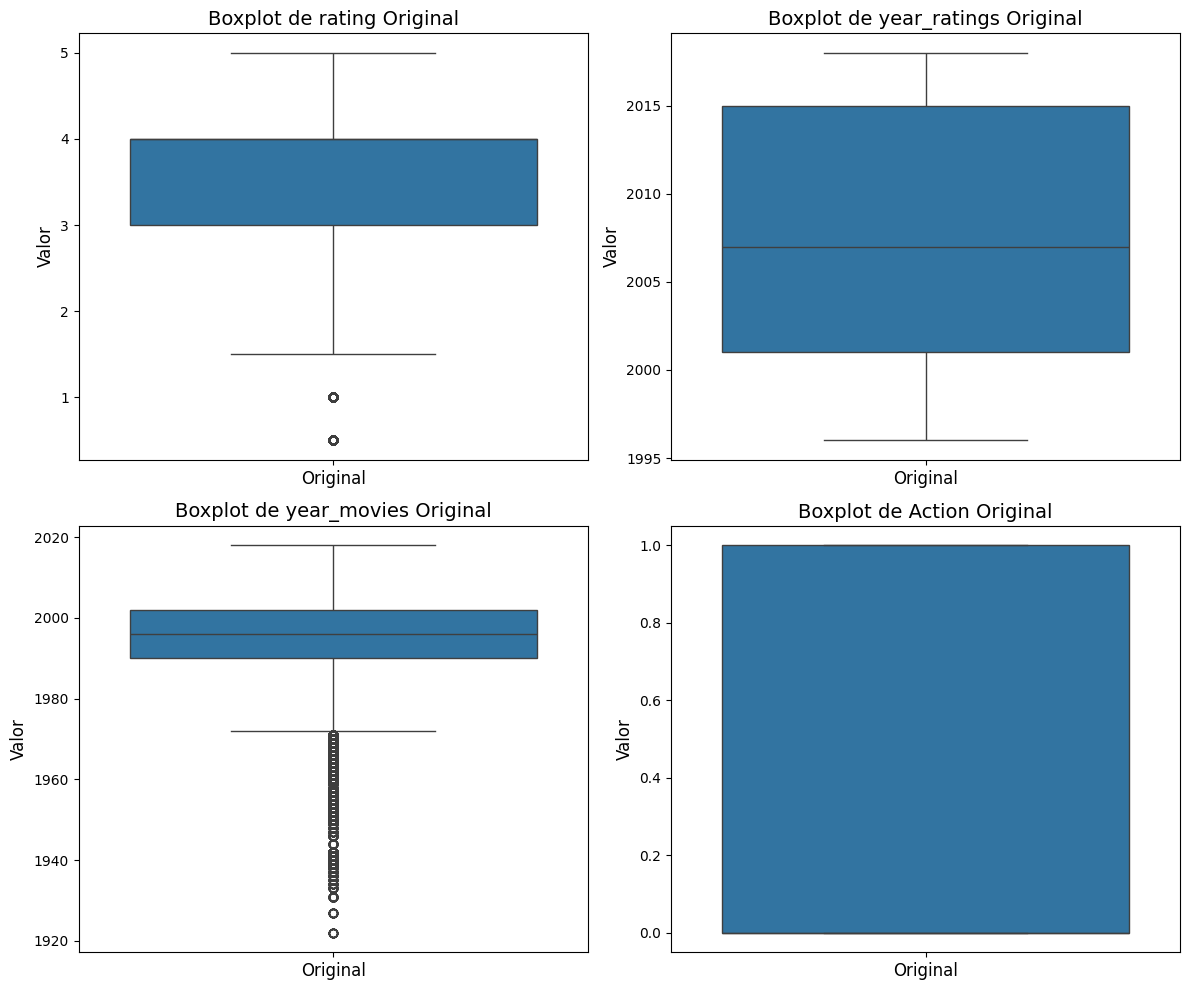

In [20]:
def visual_outliers(df):
    # Lista de columnas de géneros a excluir
    genero_cols = [
        'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
        'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
        'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
    ]

    # Seleccionar columnas numéricas y excluir las de géneros
    numeric_cols = df.select_dtypes(include='number').columns
    numeric_cols = [col for col in numeric_cols if col not in genero_cols]

    df_comparison = pd.DataFrame()
    for col in numeric_cols:
        df_comparison[f'{col}_original'] = df[col]

    num_vars = len(numeric_cols)
    n_cols = 2
    n_rows = (num_vars + n_cols - 1) // n_cols

    # Boxplots
    plt.figure(figsize=(12, 5 * n_rows))
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data=df_comparison[[f'{col}_original']])
        plt.title(f'Boxplot de {col} Original', fontsize=14)
        plt.xticks([0], ['Original'], fontsize=12)
        plt.xlabel('')
        plt.ylabel('Valor', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Histogramas con KDE
    fig_hist = make_subplots(n_rows, n_cols, subplot_titles=[f'Histograma {column}' for column in numeric_cols], shared_yaxes=True)
    for i, column in enumerate(numeric_cols):
        hist = go.Histogram(x=df[column], name=f'Histograma {column}', nbinsx=30, opacity=0.75,
                            marker=dict(color='blue', line=dict(color='black', width=1)))
        fig_hist.add_trace(hist, row=(i // n_cols) + 1, col=(i % n_cols) + 1)

        kde = gaussian_kde(df[column], bw_method='scott')
        x = np.linspace(df[column].min(), df[column].max(), 1000)
        p = kde(x)
        hist_values, bin_edges = np.histogram(df[column], bins=30)
        kde_scaled = p * np.max(hist_values) / np.max(p)

        fig_hist.add_trace(go.Scatter(x=x, y=kde_scaled, mode='lines', name=f'KDE {column}',
                                      line=dict(color='red')), row=(i // n_cols) + 1, col=(i % n_cols) + 1)

    fig_hist.update_layout(height=300 * n_rows, width=800, title_text="Histogramas variables numéricas con KDE")
    fig_hist.show()
visual_outliers(df_final)

In [21]:
# Lista de columnas de géneros a excluir
genero_cols = [
    'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

# Seleccionar columnas numéricas excluyendo los géneros
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in genero_cols]

outliers_count = {}

# Identificar y contar atípicos usando IQR
for col in numeric_cols:
    col_data = df_final[col].dropna()

    # Calcular IQR
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (df_final[col] < lower_bound) | (df_final[col] > upper_bound)
    outliers_count[col] = np.sum(outliers)

# Crear un DataFrame con las cantidades de atípicos
outliers_df = pd.DataFrame(list(outliers_count.items()), columns=['Variable', 'Cantidad de Atípicos'])
print(outliers_df)

       Variable  Cantidad de Atípicos
0        rating                  2820
1  year_ratings                     0
2   year_movies                  5029
3        Action                     0


In [22]:
# prompt: Imputación de atípicos con la media

import numpy as np
# Imputación de atípicos con la media
def impute_outliers_with_mean(df, column):
    """
    Imputa los valores atípicos de una columna con la media de la columna.

    Args:
        df: DataFrame de pandas.
        column: Nombre de la columna a imputar.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if column not in numeric_cols:
        print(f"La columna '{column}' no es numérica.")
        return df

    col_data = df[column].dropna()

    # Calcular IQR
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificar y reemplazar los valores atípicos con la media
    mean_value = col_data.mean()
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = mean_value
    return df


# Ejemplo de uso (reemplaza 'rating' con el nombre de tu columna)
for col in numeric_cols:
    df_final = impute_outliers_with_mean(df_final, col)

print(df_final.head())


  movie_id user_id  rating  year_ratings month day  \
0        1       1     4.0        2000.0     7  30   
1        3       1     4.0        2000.0     7  30   
2        6       1     4.0        2000.0     7  30   
3       47       1     5.0        2000.0     7  30   
4       50       1     5.0        2000.0     7  30   

                         title  year_movies  Action  Adventure  Animation  \
0             Toy Story (1995)       1995.0     0.0          1          1   
1      Grumpier Old Men (1995)       1995.0     0.0          0          0   
2                  Heat (1995)       1995.0     1.0          0          0   
3  Seven (a.k.a. Se7en) (1995)       1995.0     0.0          0          0   
4   Usual Suspects, The (1995)       1995.0     0.0          0          0   

   Children  Comedy  Crime  Documentary  Drama  Fantasy  Film-Noir  Horror  \
0         1       1      0            0      0        1          0       0   
1         0       1      0            0      0        0 

<ipython-input-22-75d8485e7473>:29: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2007.4222085488975' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

<ipython-input-22-75d8485e7473>:29: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.33752323069968354' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



## Pruebas de normalidad de algunas variables relevantes

In [ ]:
#Prueba de normalidad estadistica

def prueba_normalidad(df, variables):

    for var in variables:
        stat, p_value = stats.shapiro(df[var].dropna())
        print(f'Prueba de Normalidad de Shapiro-Wilk para {var}:')
        print(f'Estadístico: {stat}, Valor-p: {p_value}')
        if p_value > 0.05:
            print('No se rechaza la hipótesis nula: los datos parecen seguir una distribución normal.')
        else:
            print('Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.')
        print("\n")

# Realizar la prueba de normalidad
variables = numeric_cols
prueba_normalidad(df_final, variables)

Prueba de Normalidad de Shapiro-Wilk para rating:
Estadístico: 0.9287996397778734, Valor-p: 1.3210020596455602e-119
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


Prueba de Normalidad de Shapiro-Wilk para year_ratings:
Estadístico: 0.9334985808285998, Valor-p: 1.1555185211291349e-117
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


Prueba de Normalidad de Shapiro-Wilk para year_movies:
Estadístico: 0.8651177833168331, Valor-p: 1.467805515228787e-138
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.




/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 227186.



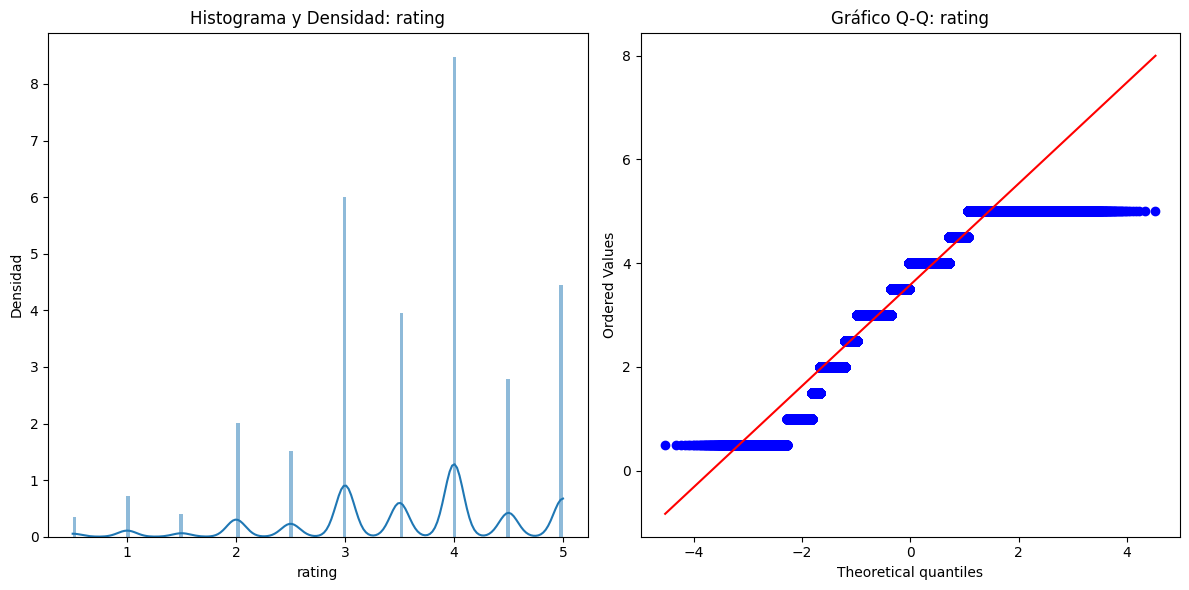

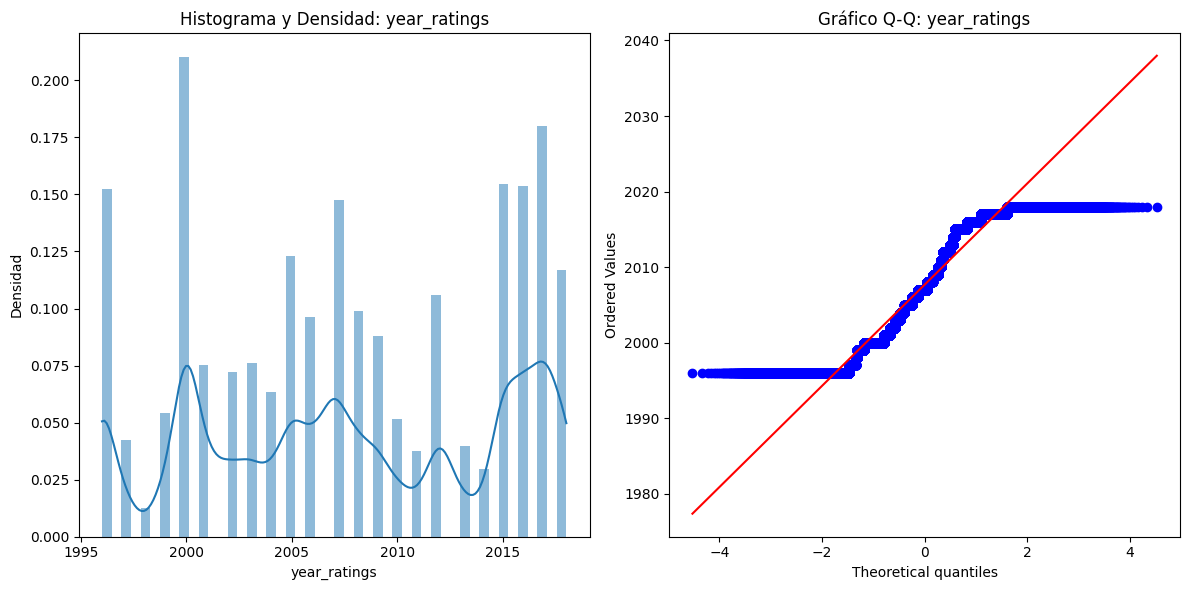

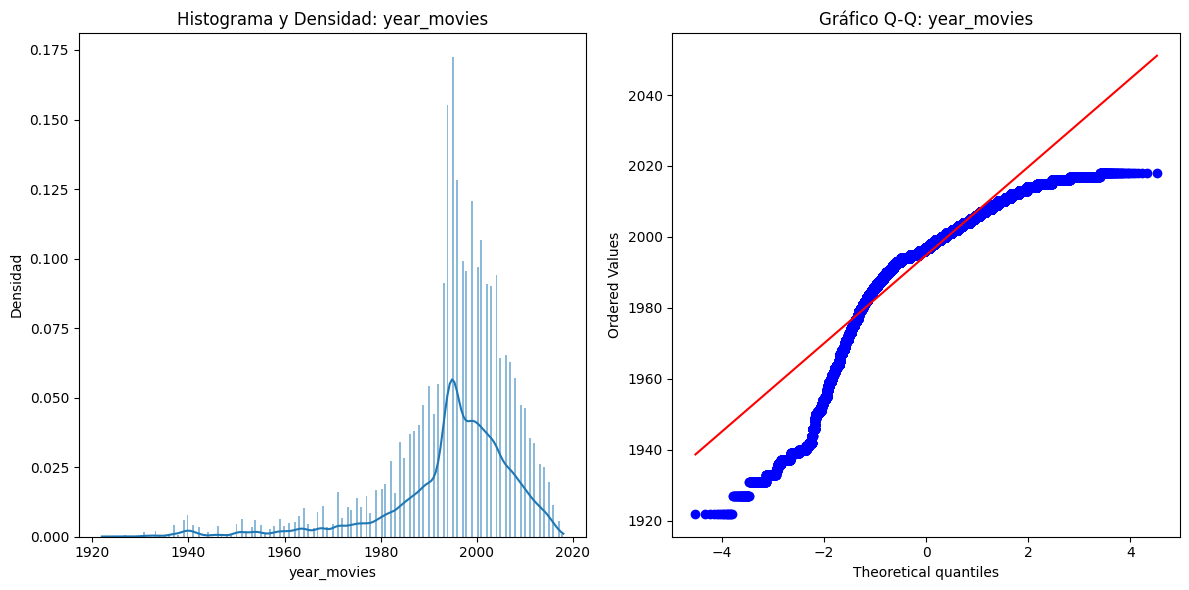

In [ ]:
#Prueba de normalidad grafica

def evaluar_normalidad(df, variables):

    for var in variables:
        plt.figure(figsize=(12, 6))

        # Histograma con línea de densidad
        plt.subplot(1, 2, 1)
        sns.histplot(df[var], kde=True, stat='density', linewidth=0)
        plt.title(f'Histograma y Densidad: {var}')
        plt.xlabel(var)
        plt.ylabel('Densidad')

        # Gráfico Q-Q
        plt.subplot(1, 2, 2)
        stats.probplot(df[var].dropna(), dist="norm", plot=plt)
        plt.title(f'Gráfico Q-Q: {var}')

        plt.tight_layout()
        plt.show()

evaluar_normalidad(df_final, variables)

### Transformación de los datos en busca de distribución normal

In [ ]:
#Copia de dataframe para modificar
dfc_transformado = df_final.copy()

# Aplicar las transformaciones logarítmicas sobre la copia
dfc_transformado['rating'] = np.log1p(dfc_transformado['rating'])
dfc_transformado['year_ratings'] = np.log1p(dfc_transformado['year_ratings'])
dfc_transformado['year_movies'] = np.log1p(dfc_transformado['year_movies'])

dfc_transformado[['rating', 'year_ratings', 'year_movies']] = StandardScaler().fit_transform(dfc_transformado[['rating', 'year_ratings', 'year_movies']])  # Estandarización

In [ ]:
numeric = dfc_transformado.select_dtypes(include=[np.number]).columns
def prueba_normalidad(df, variables):

    for var in variables:
        stat, p_value = stats.shapiro(df[var].dropna())
        print(f'Prueba de Normalidad de Shapiro-Wilk para {var}:')
        print(f'Estadístico: {stat}, Valor-p: {p_value}')
        if p_value > 0.05:
            print('No se rechaza la hipótesis nula: los datos parecen seguir una distribución normal.')
        else:
            print('Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.')
        print("\n")

# Realizar la prueba de normalidad
prueba_normalidad(dfc_transformado, numeric)

Prueba de Normalidad de Shapiro-Wilk para rating:
Estadístico: 0.8476193519810791, Valor-p: 2.4387775872769106e-142
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


Prueba de Normalidad de Shapiro-Wilk para year_ratings:
Estadístico: 0.9335299894374999, Valor-p: 1.1916728658777745e-117
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.


Prueba de Normalidad de Shapiro-Wilk para year_movies:
Estadístico: 0.8612136083647906, Valor-p: 1.9371775865942655e-139
Se rechaza la hipótesis nula: los datos no parecen seguir una distribución normal.




/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 227186.

